In [1]:
import seaborn as sns
import cv2
import os
import pandas as pd
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.models as models
import torchvision.transforms.functional as F
from PIL import Image
import torchvision
import pathlib
import pandas as pd
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torchvision.datasets import ImageFolder
from torchvision import datasets
import warnings
import random
import matplotlib.image as mpimg
warnings.filterwarnings("ignore")




In [2]:
# Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], 
                        [0.5,0.5,0.5])
])

train_path = ('/kaggle/input/brain-tumor/brain-tumor/Training/')
test_path = ('/kaggle/input/brain-tumor/brain-tumor/Testing/')

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=data_transforms),
    batch_size=32, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=data_transforms),
    batch_size=32, shuffle=False
)

train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [4]:
class TumorDetectionModel(nn.Module):
    def __init__(self, num_classes):
        super(TumorDetectionModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        return self.resnet(x)
    
model = TumorDetectionModel(num_classes=2)
model.to(device)

TumorDetectionModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [5]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
best_accuracy_3 = 0.0
criterion = nn.CrossEntropyLoss()
tr_losses = []
test_losses = []
accuracies_train = []
accuracies_test = []

for epoch in range(12):
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0

    for images, labels in train_loader:
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    tr_losses.append(train_loss)
    accuracies_train.append(train_accuracy)
    
    
    model.eval()
    test_loss = 0.0
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        test_loss += loss.item() 
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    test_loss /= len(test_loader)
    accuracies_test.append(test_accuracy)
    
    
    print('Epoch: '+str(epoch+1)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    if test_accuracy>best_accuracy_3:
        torch.save(model,'best_checkpoint.model')
        best_accuracy_3=test_accuracy

     

Epoch: 1 Train Loss: 42.20547164417803 Train Accuracy: 0.9217291632552809 Test Accuracy: 0.8997524752475248
Epoch: 2 Train Loss: 28.350838739424944 Train Accuracy: 0.9446536761093827 Test Accuracy: 0.9189356435643564
Epoch: 3 Train Loss: 23.261387437582016 Train Accuracy: 0.958080890781071 Test Accuracy: 0.9164603960396039
Epoch: 4 Train Loss: 22.28157038241625 Train Accuracy: 0.9590633699033896 Test Accuracy: 0.9288366336633663
Epoch: 5 Train Loss: 22.652146267704666 Train Accuracy: 0.9588996233830032 Test Accuracy: 0.9288366336633663
Epoch: 6 Train Loss: 22.402971846517175 Train Accuracy: 0.9574259046995252 Test Accuracy: 0.9158415841584159
Epoch: 7 Train Loss: 21.01677234703675 Train Accuracy: 0.9618470607499591 Test Accuracy: 0.9300742574257426
Epoch: 8 Train Loss: 19.458372741006315 Train Accuracy: 0.9657769772392336 Test Accuracy: 0.9412128712871287
Epoch: 9 Train Loss: 18.294914779718965 Train Accuracy: 0.9656132307188472 Test Accuracy: 0.9474009900990099
Epoch: 10 Train Loss: 1

In [6]:
print(best_accuracy_3)

0.9474009900990099


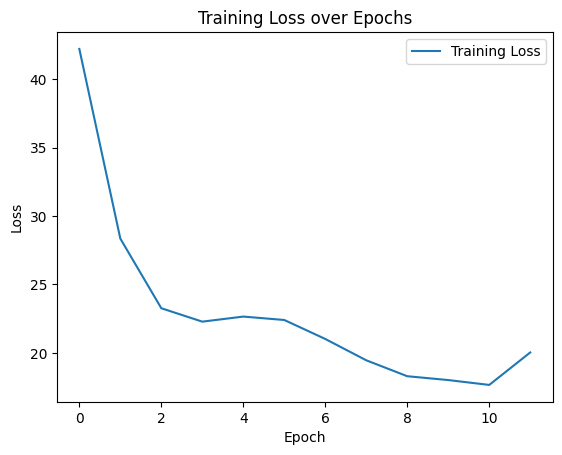

In [7]:
plt.plot(tr_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

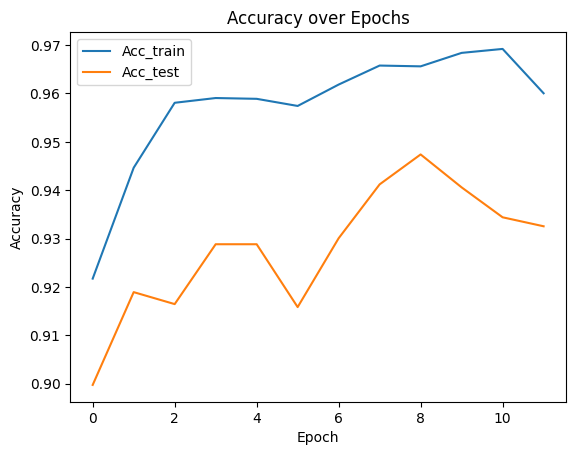

In [10]:
plt.plot(accuracies_train, label='Acc_train')
plt.plot(accuracies_test, label='Acc_test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()